#  <center><h2>NCC实现图像视差匹配</h2></center>

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

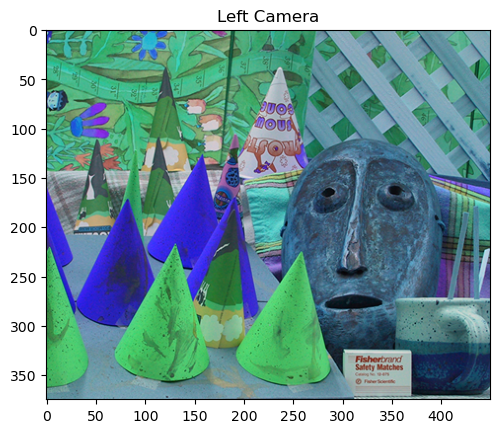

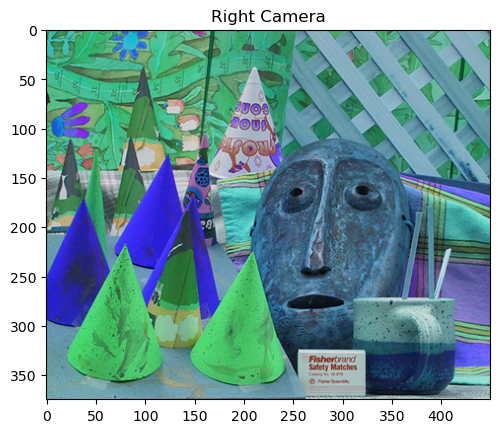

(<matplotlib.image.AxesImage at 0x24dab1c9ca0>, None)

In [8]:
im1 = './img/input/im2.png'
im2 = './img/input/im6.png'
plt.title("Left Camera")
plt.imshow(cv2.imread('./img/input/im2.png')), plt.show()
plt.title("Right Camera")
plt.imshow(cv2.imread('./img/input/im6.png')), plt.show()

<ipython-input-9-df8f48bb181b>:60: RuntimeWarning: invalid value encountered in divide
  tmp_ncc4 = tmp_ncc1/tmp_ncc2


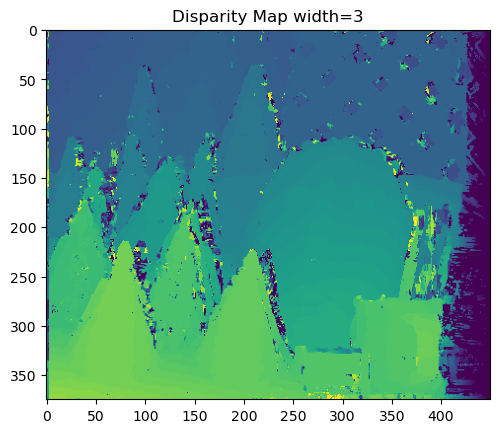

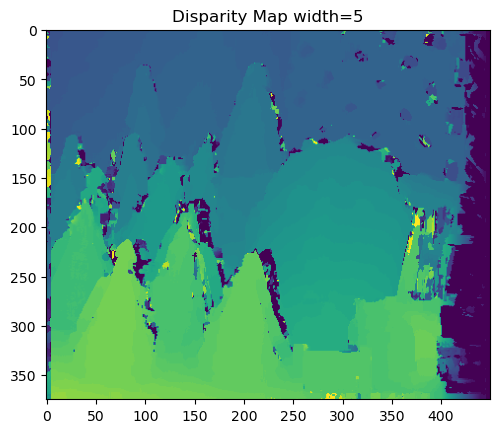

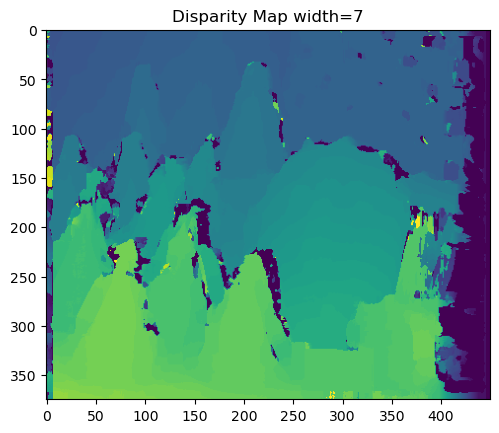

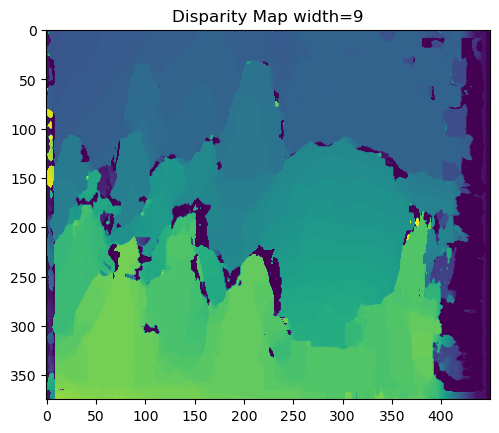

In [9]:
def translation(image, width):
    step = width
#     print(step)
    shifted = []
    for i in range(0, step+1):
        for j in range(0, step+1):
            if i==0 and j==0:
                M1 = np.float32([[1, 0, i], [0, 1, j]])
                shifted.append(cv2.warpAffine(image, M1, (image.shape[1], image.shape[0])))
            elif i==0 and j!=0:
                M1 = np.float32([[1, 0, i], [0, 1, j]])
                M2 = np.float32([[1, 0, i], [0, 1, -j]])
                shifted.append(cv2.warpAffine(image, M1, (image.shape[1], image.shape[0])))
                shifted.append(cv2.warpAffine(image, M2, (image.shape[1], image.shape[0])))
            elif i!=0 and j==0:
                M1 = np.float32([[1, 0, i], [0, 1, j]])
                M2 = np.float32([[1, 0, -i], [0, 1, j]])
                shifted.append(cv2.warpAffine(image, M1, (image.shape[1], image.shape[0])))
                shifted.append(cv2.warpAffine(image, M2, (image.shape[1], image.shape[0])))
            else:
                M1 = np.float32([[1, 0, i], [0, 1, j]])
                M2 = np.float32([[1, 0, -i], [0, 1, -j]])
                M3 = np.float32([[1, 0, -i], [0, 1, j]])
                M4 = np.float32([[1, 0, i], [0, 1, -j]])
                shifted .append(cv2.warpAffine(image, M1, (image.shape[1], image.shape[0])))
                shifted.append(cv2.warpAffine(image, M2, (image.shape[1], image.shape[0])))
                shifted.append(cv2.warpAffine(image, M3, (image.shape[1], image.shape[0])))
                shifted.append(cv2.warpAffine(image, M4, (image.shape[1], image.shape[0])))

#     print(len(shifted))
    return np.array(shifted)

#I(x,y)-avg(I(x,y))
def img_sub_avg(img_shifted, avg_img):
    channel, height, width = img1_shifted.shape
    tmp_ncc1 = np.zeros([channel, height, width])
    for i in range(channel):
        tmp_ncc1[i] = img_shifted[i] - avg_img
    return tmp_ncc1

def NCC(img1_sub_avg,img2_sub_avg, threshold, max_d):
    #设立阈值
    channel, height, width = img1_sub_avg.shape
    thershould_shifted = np.zeros([channel, height, width])
    ncc_max = np.zeros([height, width])
    ncc_d = np.zeros([height, width])
    for j in range(3, max_d):
        tmp_ncc1 = np.zeros([height, width])
        tmp_ncc2 = np.zeros([height, width])
        tmp_ncc3 = np.zeros([height, width])
        for k in range(channel):
            M1 = np.float32([[1, 0, -j - 1], [0, 1, 0]])
            thershould_shifted[k] = cv2.warpAffine(img1_sub_avg[k], M1, (img1_sub_avg.shape[2], img1_sub_avg.shape[1]))
        for i in range(channel):
            tmp_ncc1 += (img2_sub_avg[i])*(thershould_shifted[i])
            tmp_ncc2 += pow(img2_sub_avg[i], 2)
            tmp_ncc3 += pow(thershould_shifted[i], 2)

        tmp_ncc2 = np.sqrt(tmp_ncc2*tmp_ncc3)
        tmp_ncc4 = tmp_ncc1/tmp_ncc2
        for m in range(height):
            for n in range(width):
                if tmp_ncc4[m, n] > ncc_max[m ,n] and tmp_ncc4[m, n] > threshold:
                    ncc_max[m, n] = tmp_ncc4[m, n]
                    ncc_d[m , n] = j
#     for i in ncc_d:
#         print(i)
    return ncc_max, ncc_d

if __name__ == "__main__":
    img1 = cv2.imread(im1, cv2.CV_8UC1)
    img2 = cv2.imread(im2, cv2.CV_8UC1)
    rows, cols = img1.shape
    disparity = np.zeros([rows, cols])
    NCC_value = np.zeros([rows, cols])
    deeps = np.zeros([rows, cols])
    
    # 窗口大小
    width = [3, 5, 7, 9]
    for wid in width:
        # 用卷积核做均值滤波
        avg_img1 = cv2.blur(img1, (wid, wid))
        avg_img2 = cv2.blur(img2, (wid, wid))
        fimg1 = img1.astype(np.float32)
        fimg2 = img2.astype(np.float32)
        avg_img1 = avg_img1.astype(np.float32)
        avg_img2  = avg_img2.astype(np.float32)
        img1_shifted = translation(fimg1, wid)
        img2_shifted = translation(fimg2, wid)
        img1_sub_avg = img_sub_avg(img1_shifted, avg_img1)
        img2_sub_avg = img_sub_avg(img2_shifted, avg_img2)
        ncc_max, ncc_d = NCC(img1_sub_avg,img2_sub_avg, threshold = 0.5, max_d = 64)
        #     print(img1_shifted.shape)
        disp = cv2.normalize(ncc_d, ncc_d, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX,dtype=cv2.CV_8U)

        plt.title(f'Disparity Map width={wid}')
        plt.imshow(disp), plt.show()